In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import _autolag
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import seaborn as sns
#sns.set_theme()
#from scipy.stats import pearsonr

DATA PREPARATION

In [188]:
data_df=pd.read_excel('Gas Data processed.xlsx',sheet_name="code_monthly_deflated_avg")
df=data_df.loc[2:140,["months", "price_gas", "price_brent_gbp","open_interest_gas","lng","storage","temperature","euas","supply","coal_gbp","eurgbp","gbpusd","churn","temp_deviation","price_range","price_gas_avg"]] 
print(df)


#start at 15 for churn
#first ets value at line 38

     months  price_gas  price_brent_gbp  open_interest_gas       lng  \
2    Dec 09  35.715393        52.288674             12.590  1.670000   
3    Jan 10  41.151481        54.302797             13.650  1.540000   
4    Feb 10  38.872449        55.081704             12.720  1.330000   
5    Mar 10  33.967453        58.531509             18.530  1.320000   
6    Apr 10  35.590807        62.149675             19.305  1.720000   
..      ...        ...              ...                ...       ...   
136  Feb 21  40.967919        40.980074             41.235  1.897236   
137  Mar 21  40.658930        43.494060             44.325  2.321223   
138  Apr 21  46.712534        42.188306             37.515  2.111904   
139  May 21  57.411172        43.616761             35.298  1.428956   
140  Jun 21  64.147268        47.484969             35.409  1.016736   

      storage  temperature     euas     supply   coal_gbp   eurgbp    gbpusd  \
2    0.660000         4.15  10.6420  10.660000  58.7071

In [189]:
#Vector:
dprice_gas=df.price_gas
dprice_gas_avg=df.price_gas_avg
dprice_brent_gbp=df.price_brent_gbp
dOI=df.open_interest_gas
dtemp=df.temperature
dtempdev=df.temp_deviation
dstore=df.storage
dlng=df.lng
dsupply=df.supply
dEUAs=df.euas
dEUR=df.eurgbp
dUSD=df.gbpusd
dcoal=df.coal_gbp
dchurn=df.churn
drange=df.price_range

time= df.months

DataSeries=[dtempdev, dprice_brent_gbp, dstore, dlng, dprice_gas_avg]
#DataSeries=[dtempdev, dEUR, dprice_brent_gbp, dlng, dstore, dOI, dprice_gas_avg]


#DataSeries=[dprice_gas,dsupply, dlng, dstore, dtemp, dtempdev]

#DataSeries=[dprice_gas,dprice_brent_gbp,dOI,dstore,dlng,dtemp,dsupply,dEUAs,dchurn,dtempdev,dEUR,dUSD,dcoal]
df_test = pd.concat(DataSeries,axis=1)

In [190]:
######### INITIAL DATA TESTS #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary

from statsmodels.tsa.stattools import adfuller, kpss
######## NORMALITY TEST V2 ########

def normality_test_matrix(data, variables, test):    
    """Check normality test to comply with general model assumptions.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    test      : type of test to perform
    """

    col=['test statistic ','p-value ', 'lags used ']
    df = pd.DataFrame(np.zeros((len(variables), 3)), columns=col, index=variables)
    for r in df.index:
        if test == "Dickey-Fuller":
            dftestdickey = adfuller(data[r].values, autolag='AIC')
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestdickey[c]           
        elif test == "KPSS":
            dftestkpss = kpss(data[r].values, regression='c', nlags="auto")
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestkpss[c]

    print("Results for "+test+" test")
    df.columns = [var + test for var in col]

    #df.index = [var for var in variables]s
    return df


### styles ###

def highlight_cells_DF(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e < 0.05 else highlight_false for e in series]  

def highlight_cells_KPSS(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e > 0.05 else highlight_false for e in series]  


dfdifull = normality_test_matrix(df_test, variables = df_test.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)

Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
temp_deviation,-7.844900,0.000000,0.000000
price_brent_gbp,-1.564309,0.501493,2.000000
storage,-2.275218,0.180085,11.000000
lng,-2.895856,0.045832,3.000000
price_gas_avg,-3.105076,0.026180,11.000000


In [191]:
dfkpss = normality_test_matrix(df_test, variables = df_test.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,test statistic KPSS,p-value KPSS,lags used KPSS
temp_deviation,0.512136,0.038933,4.000000
price_brent_gbp,1.194108,0.010000,6.000000
storage,0.148617,0.100000,5.000000
lng,0.516955,0.037848,5.000000
price_gas_avg,0.437124,0.061154,6.000000


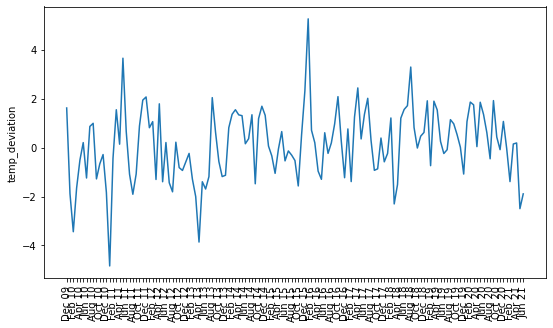

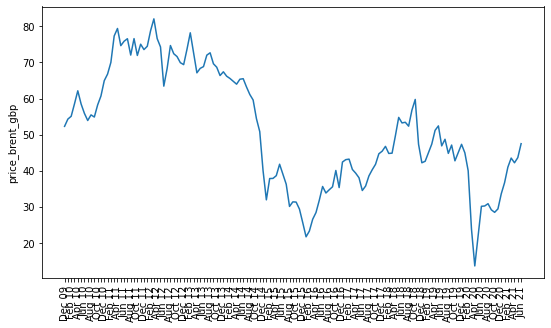

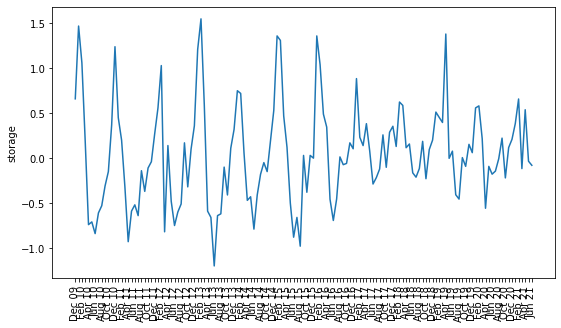

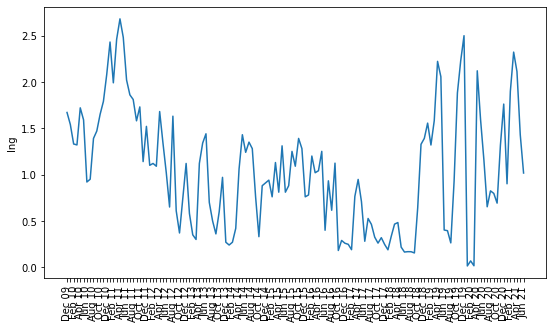

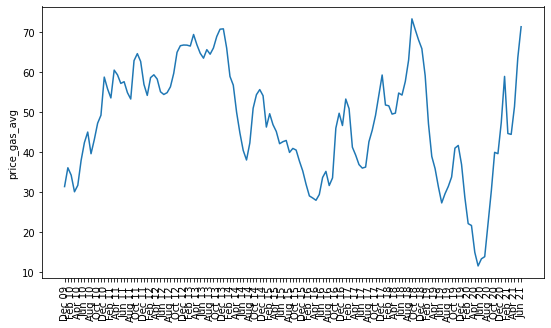

In [192]:
######### DATA CORRECTION #########
#ideally, for each set, apply specific changes
# detrending for linear processes
# differences for random walks 
# other ? non linear processes

#### initiate corrected series
DataSeriesCorr=[]

#### select correction mode
TypeCorr = 'none' # 'HP' for filtering or 'log' or 'bothHPlog'

HP =['gbpusd', 'open_interest_gas','churn','eurgbp','gbpusd','price_brent_gbp','price_gas_avg']
loga = ['price_brent_gbp','price_gas_avg']

for df in DataSeries:

    if TypeCorr == "log" or TypeCorr == 'bothHPlog' or TypeCorr == 'mixed':
            if df.name in loga or TypeCorr =="log":
                df_log = pd.Series(np.log(df))
                df = df_log


    if TypeCorr == 'HP' or TypeCorr == 'bothHPlog' or TypeCorr == 'mixed':
        if df.name in HP or TypeCorr == 'HP':
            cycle, trend = sm.tsa.filters.hpfilter(df, 129600)
            plt.plot(trend)
            plt.plot(cycle)
            cycle.name = df.name
            df = cycle

    if TypeCorr == 'diff':
        df_diff = df.diff().dropna()
        df = df_diff

    plt.figure(figsize=(9, 5))
    if TypeCorr == 'diff':        
        plt.plot(time.iloc[1:], df)
    else: 
        plt.plot(time, df)
    plt.ylabel(df.name)
    ax = plt.gca()
    plt.xticks(rotation=90)
    for label in ax.get_xaxis().get_ticklabels()[1::2]:
        label.set_visible(False)
    plt.show()
    DataSeriesCorr.append(df)

df_corr = pd.concat(DataSeriesCorr,axis=1)



In [193]:
######### STATIONARITY DATA TEST #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary


dfdifull = normality_test_matrix(df_corr, variables = df_corr.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)


Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
temp_deviation,-7.844900,0.000000,0.000000
price_brent_gbp,-1.564309,0.501493,2.000000
storage,-2.275218,0.180085,11.000000
lng,-2.895856,0.045832,3.000000
price_gas_avg,-3.105076,0.026180,11.000000


In [194]:
dfkpss = normality_test_matrix(df_corr, variables = df_corr.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,test statistic KPSS,p-value KPSS,lags used KPSS
temp_deviation,0.512136,0.038933,4.000000
price_brent_gbp,1.194108,0.010000,6.000000
storage,0.148617,0.100000,5.000000
lng,0.516955,0.037848,5.000000
price_gas_avg,0.437124,0.061154,6.000000


In [195]:
#### EXPORT NORMALISED DATA ####


df_export = df_corr

#df_export.insert(0,'months',time)
#print(df_export)
#df_export.to_excel(r'export_normal_data.xlsx', index = False)

#df_corr.drop(columns=['months'])
#print(df_corr)

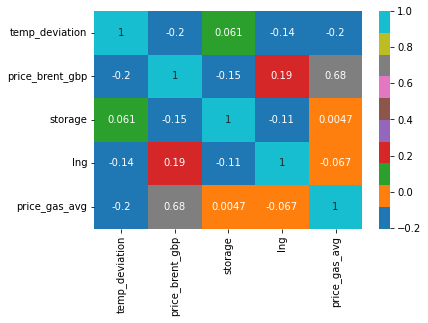

In [196]:
#### CORRELATION MATRIX ####

CorrelationMatrix=df_corr.corr()
ax=sns.heatmap(CorrelationMatrix, annot=True, cmap="tab10")


     temp_deviation  price_brent_gbp   storage       lng  price_gas_avg
2          1.618333        52.288674  0.660000  1.670000      31.429545
3         -1.888333        54.302797  1.470000  1.540000      36.131000
4         -3.440000        55.081704  1.060000  1.330000      34.285500
5         -1.653333        58.531509  0.190000  1.320000      30.129130
6         -0.511667        62.149675 -0.740000  1.720000      31.747000
..              ...              ...       ...       ...            ...
136       -1.390000        40.980074  0.658246  1.897236      44.696000
137        0.146667        43.494060 -0.116558  2.321223      44.480870
138        0.188333        42.188306  0.538452  2.111904      51.430500
139       -2.496667        43.616761 -0.034491  1.428956      63.611579
140       -1.893333        47.484969 -0.079826  1.016736      71.395909

[139 rows x 5 columns]


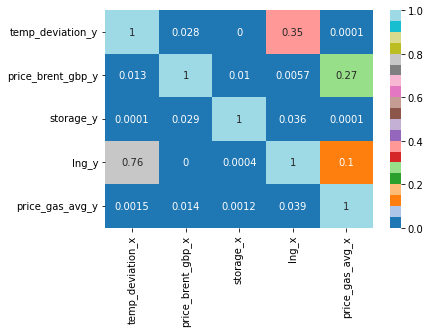

In [197]:
#### CORRECTED GRANGER CAUSALITY ####

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    #plot
    sns.heatmap(df, annot=True, cmap="tab20")
    #return df


##### actual test
print(df_corr)
grangers_causation_matrix(df_corr, variables = df_corr.columns)        


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


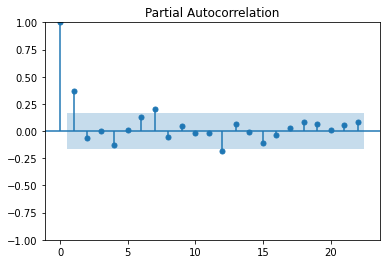

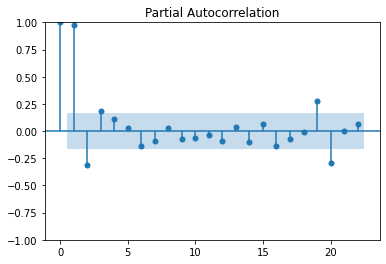

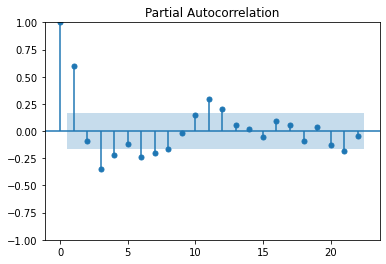

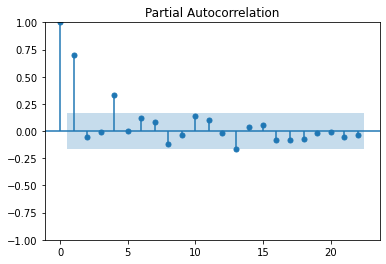

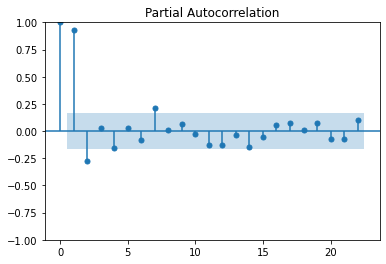

In [198]:
######### LAG LENGTH CRITERIA ######### either multiple of frequency or Schwarz, akaike, hannan-quinn, bayesian 

for df in DataSeries:
    plot_pacf(df)
    plt.show()

# for df in DataSeries:
#     lag_selection = _autolag(mod=VAR,endog=df, exog=df, startlag=1, maxlag=30, method="aic")
#     lag_selection.results()
#     #plt.show()


In [199]:
##### MODEL FITTING #####

model = VAR(df_corr)
x = model.select_order()
x.summary()
#model_fit = model.fit(maxlags=10, ic="aic") #aic, or bic
#model_fit.summary()


#model_fit.plot()


,AIC,BIC,FPE,HQIC
0,8.566,8.679,5250.,8.612
1,3.185,3.861*,24.18,3.460*
2,3.065,4.303,21.48,3.568
3,2.979,4.780,19.81,3.711
4,2.873,5.237,17.97,3.833
5,2.853,5.779,17.86*,4.042
6,3.002,6.491,21.19,4.419
7,3.193,7.244,26.43,4.839
8,3.140,7.755,26.12,5.015
9,3.271,8.448,31.41,5.374


In [200]:
##### MODEL FITTING BASED ON LAG CRITERIA RESULTS ######

lag_order =4
model_fit = model.fit(6)
model_fit.summary()

#model_fit.plot()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 20, Aug, 2022
Time:                     17:41:50
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    6.49729
Nobs:                     133.000    HQIC:                   4.49765
Log likelihood:          -996.662    FPE:                    23.8665
AIC:                      3.12884    Det(Omega_mle):         8.37198
--------------------------------------------------------------------
Results for equation temp_deviation
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      1.176511         0.618503            1.902           0.057
L1.temp_deviation          0.498489         0.101085            4.931           0.000
L1.price_brent_gbp         0.05

True


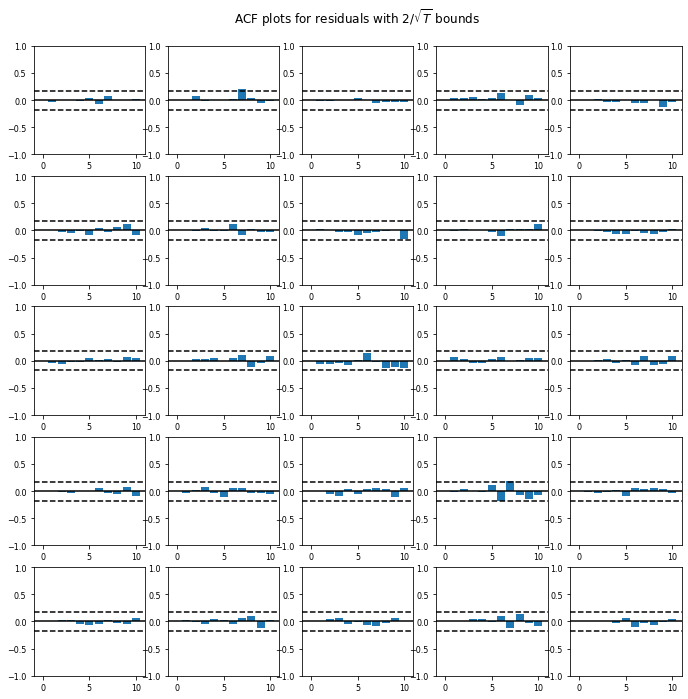

In [201]:
######### STABILITY RESIDUALS AUTOCORRELATION #########
accor = model_fit.plot_acorr()

stab = model_fit.is_stable()
print(stab)

#if residuals out of range -> unstable model 

In [202]:
######### GRANGER CAUSALITY TEST #########
#for gas price
#GrangerCausality = model_fit.test_causality('price_gas', ['lng'], kind='f')
#print(GrangerCausality.summary())

#granger causality test : HO not rejected => there is some causality between the variables

#importance of the order: if p value higher, does it mean that one variable is generating the other ?

In [203]:
######### NORMALITY TEST #########

TestNorm = model_fit.test_normality()
print(TestNorm.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         42.40          18.31   0.000 10
----------------------------------------


In [204]:
######### Whiteness TEST ######### (absence of significant residual autocorrelations)

TestWhite = model_fit.test_whiteness(nlags=18)
print(TestWhite.summary())

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 18 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         311.6          341.4   0.311 300
-----------------------------------------


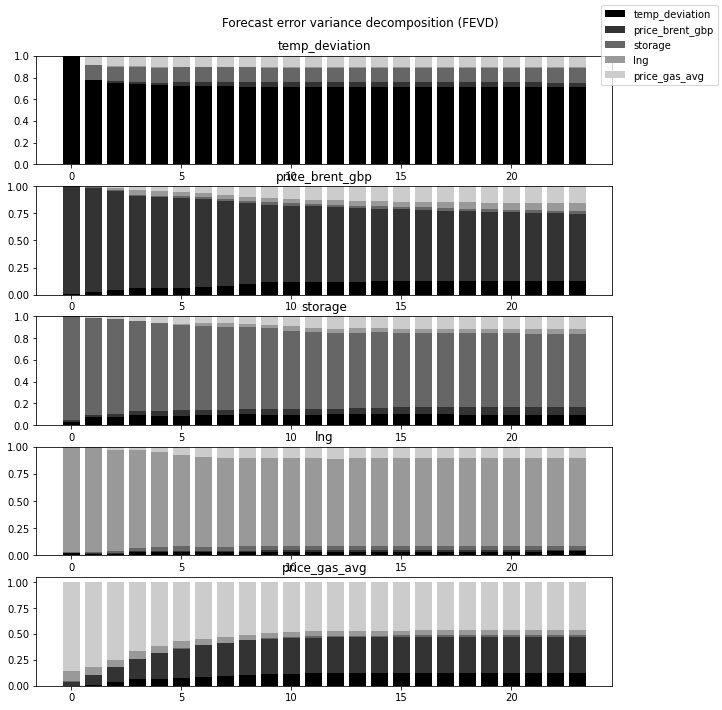

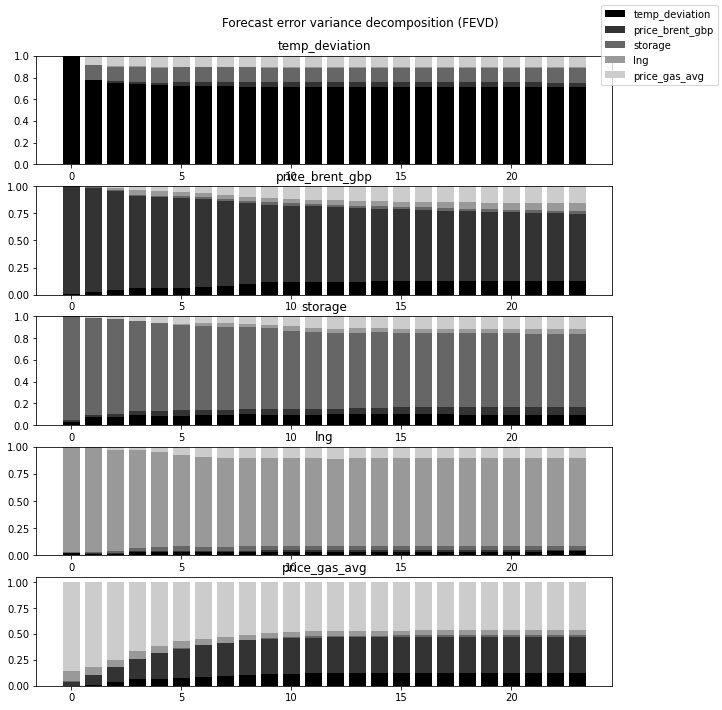

In [205]:
######### FORECAST VARIANCE ERROR DECOMPOSITION: #########

#only for 20 periods
n=24
VD = model_fit.fevd(n)
#fevd.summary()

#affichage pour n périodes
VD.plot()

IMPULSE RESPONSE ANALYSIS:

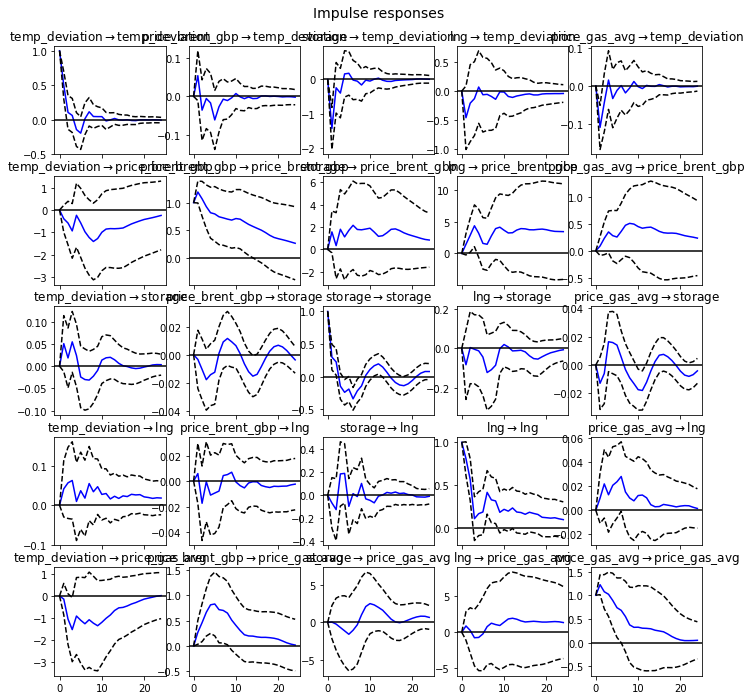

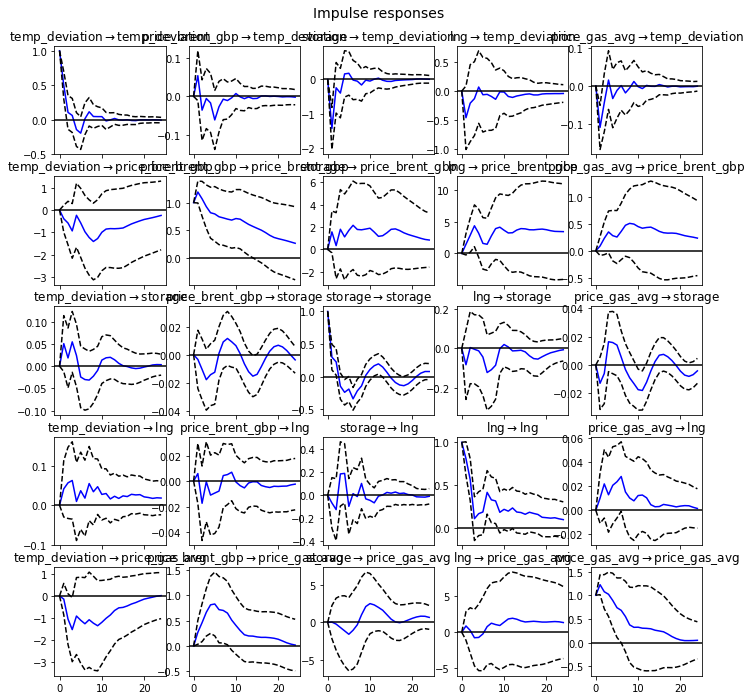

In [206]:
Impulse = model_fit.irf(24)

Impulse.plot()

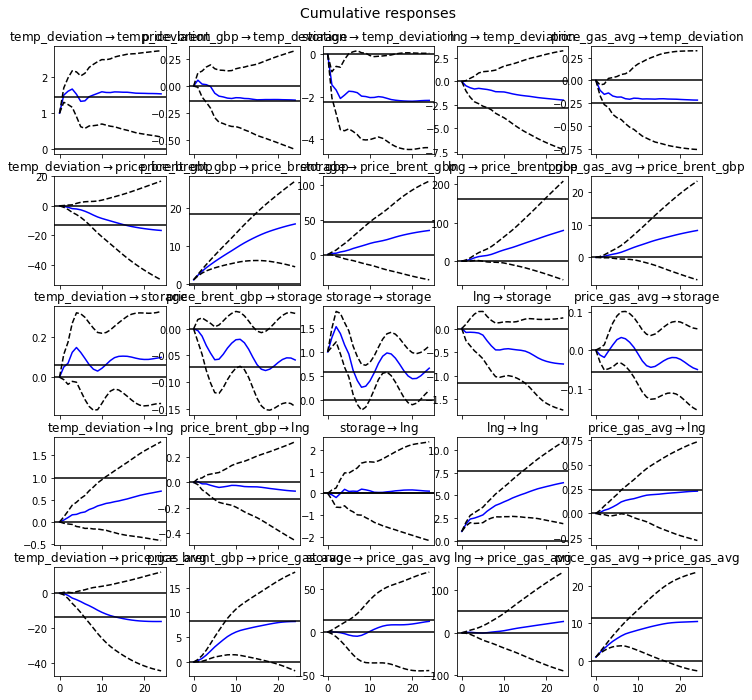

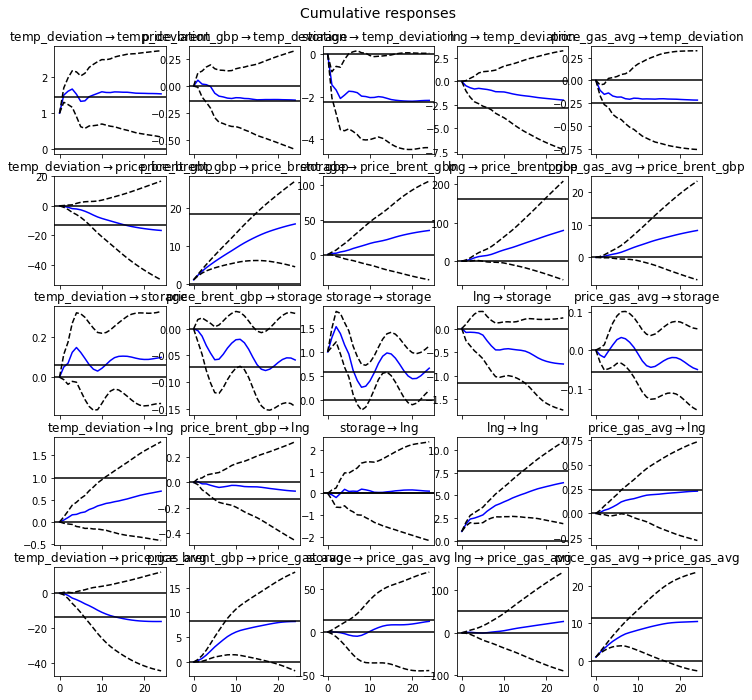

In [207]:
Impulse.plot_cum_effects(orth=False)

OTHER MODELS

In [208]:
from statsmodels.tsa.api import SVAR
 
lag_order = 4

#A = np.asarray([[0, 0, 0],['E', 0, 0],[0, 'E', 0]])
#B = np.asarray([['E', 0, 0], [0, 'E', 0], [0, 0, 'E']])

#A = np.asarray([[1, 0, 0, 0, 0], ['E', 1, 0, 0, 'E'],['E', 0, 1, 0, 'E'],[0, 0, 'E', 1, 'E'],['E', 'E', 'E', 'E', 1]])
A = np.asarray([['E', 0, 0, 0, 0], [0, 'E', 0, 0, 0],['E', 0, 'E', 0, 'E'],['E', 'E', 0, 'E', 'E'],['E', 'E', 'E', 'E', 'E']]) # with temp, storage, lng, brent, price_gas
#B = np.asarray([['E', 0, 0, 0, 0], [0, 'E', 0, 0, 0],[0, 0, 'E', 0, 0],[0, 0, 0, 'E', 0],[0, 0, 0, 0, 'E']]) # with temp, storage, lng, brent, price_gas


StructModel = SVAR(df_corr,svar_type='A', A=A)

#dtempdev, dstore, dlng, dprice_brent_gbp, drange

ResSVAR = StructModel.fit(maxlags=lag_order, maxiter=10000, maxfun=10000, solver='bfgs')



/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [209]:
##### IS STABLE ? #####
Stab = ResSVAR.is_stable()
print("SVAR model is stable ? :   ",Stab)

SVAR model is stable ? :    True


In [210]:
######### Whiteness TEST ######### (absence of significant residual autocorrelations)

TestWhite = ResSVAR.test_whiteness(nlags=24)
print(TestWhite.summary())

#Portmanteau test

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 24 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         488.5          553.1   0.635 500
-----------------------------------------


In [211]:
######### NORMALITY TEST #########

TestNorm = ResSVAR.test_normality()
print(TestNorm.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         49.94          18.31   0.000 10
----------------------------------------


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Pyt

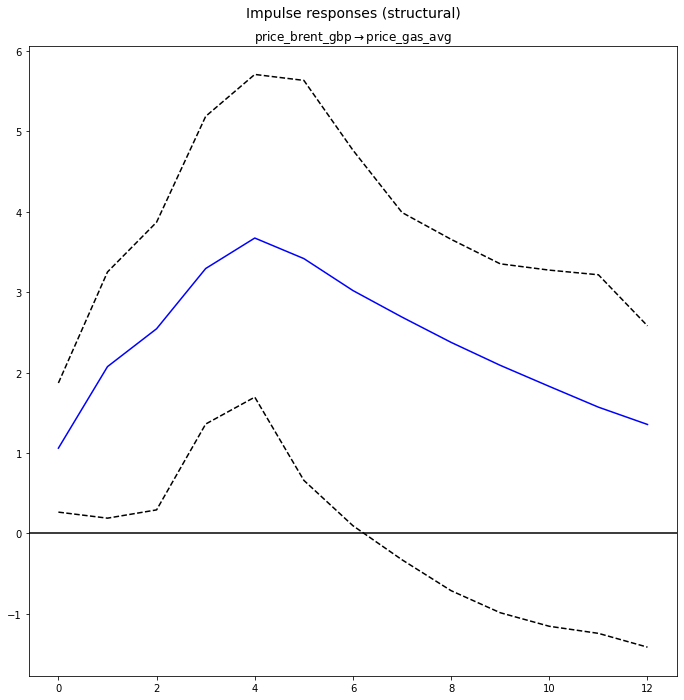

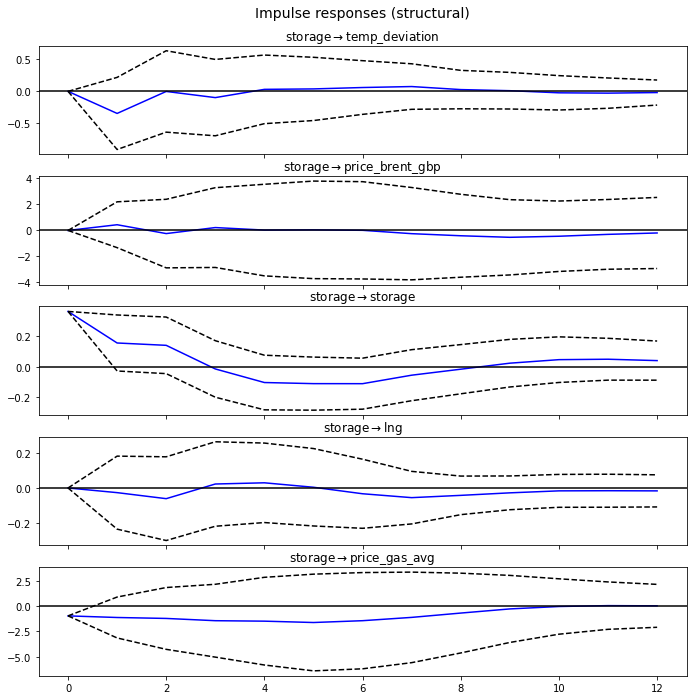

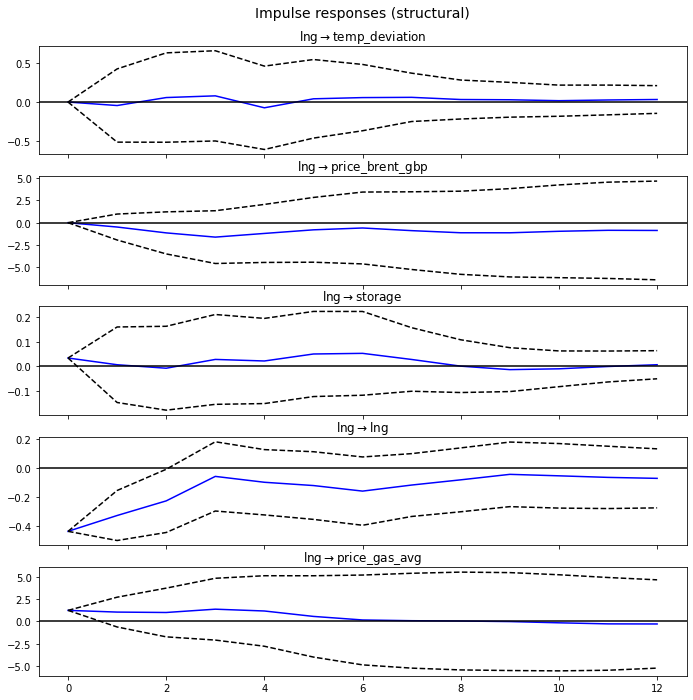

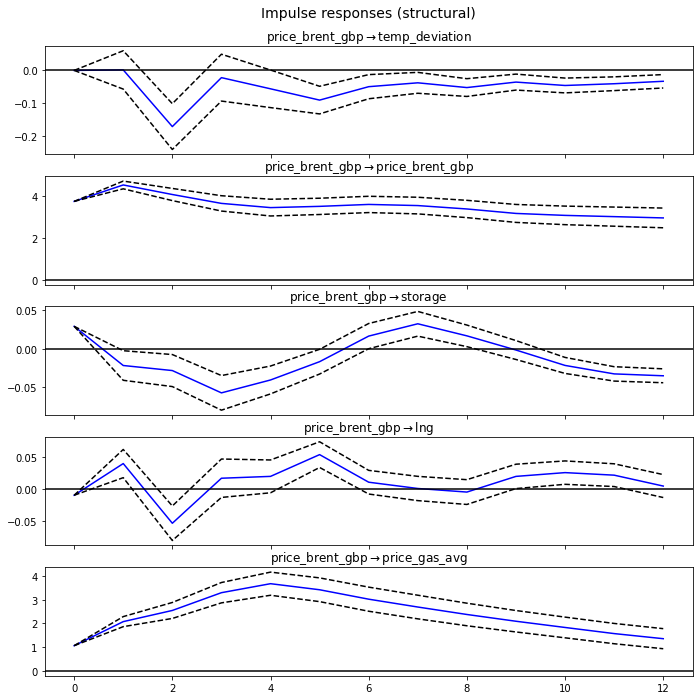

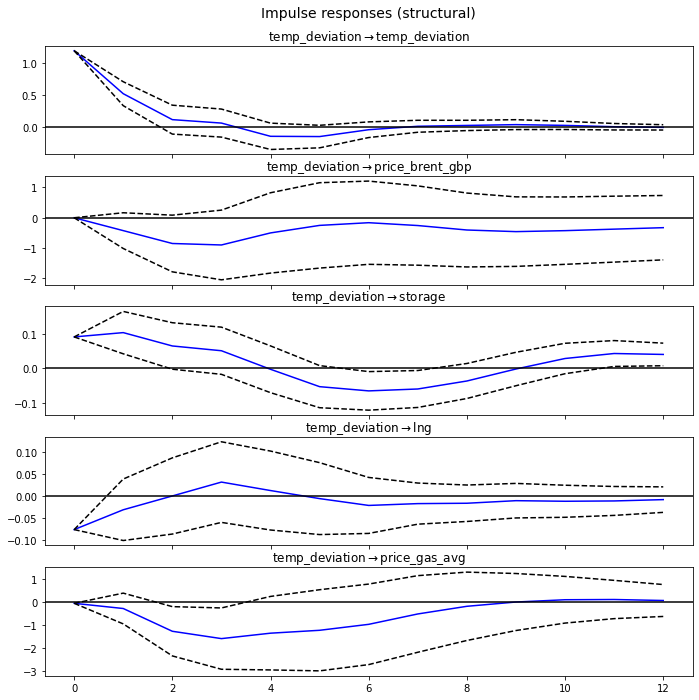

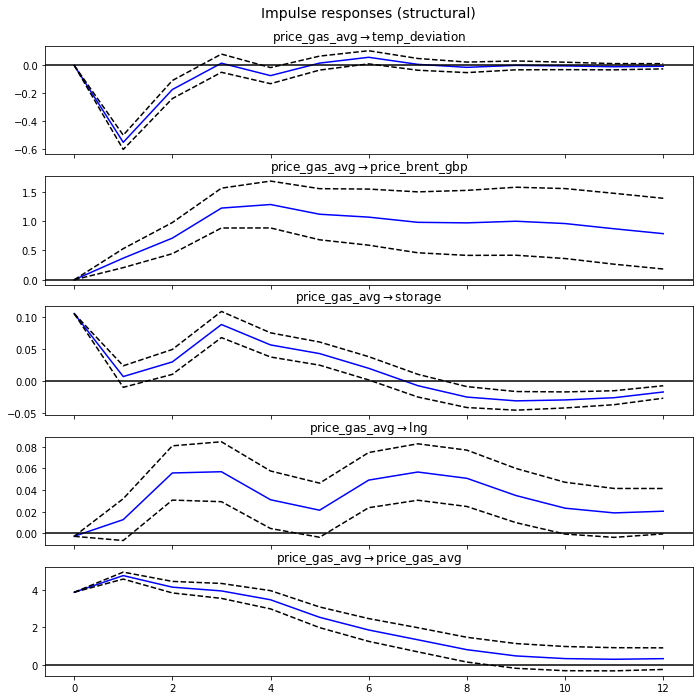

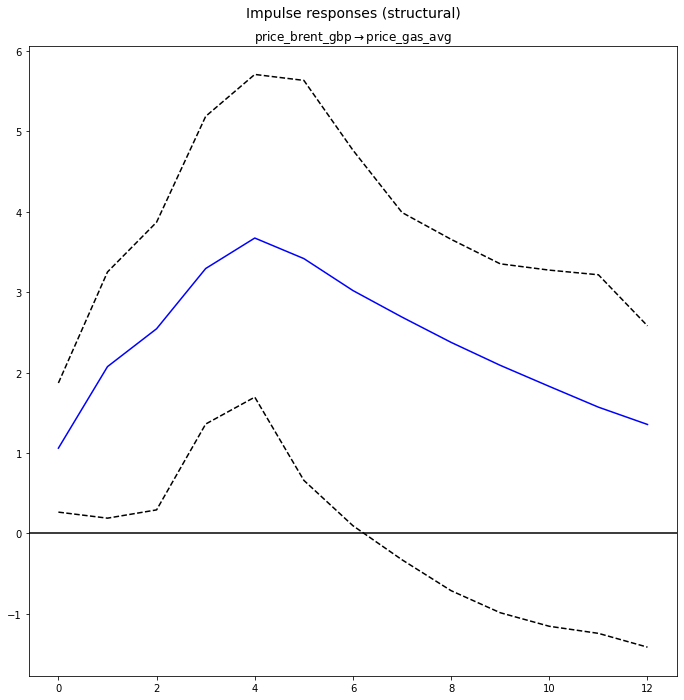

In [212]:
#### IR ####


ResSVAR.irf(periods=12).plot(impulse='storage', plot_stderr=True,stderr_type='asym', repl=100)
ResSVAR.irf(periods=12).plot(impulse='lng', plot_stderr=True,stderr_type='asym', repl=100)
ResSVAR.irf(periods=12).plot(impulse='price_brent_gbp', plot_stderr=True,stderr_type='asym', repl=100)
ResSVAR.irf(periods=12).plot(impulse='temp_deviation', plot_stderr=True,stderr_type='asym', repl=100)

ResSVAR.irf(periods=12).plot(impulse='price_gas_avg', plot_stderr=True,stderr_type='asym', repl=100)


ResSVAR.irf(periods=12).plot(impulse='price_brent_gbp', response="price_gas_avg" ,plot_stderr=True, stderr_type='mc', repl=100)




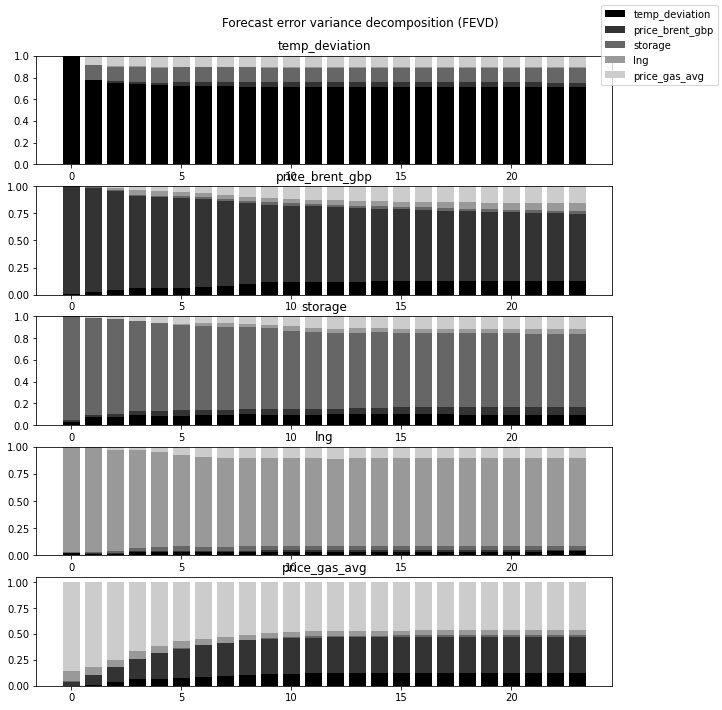

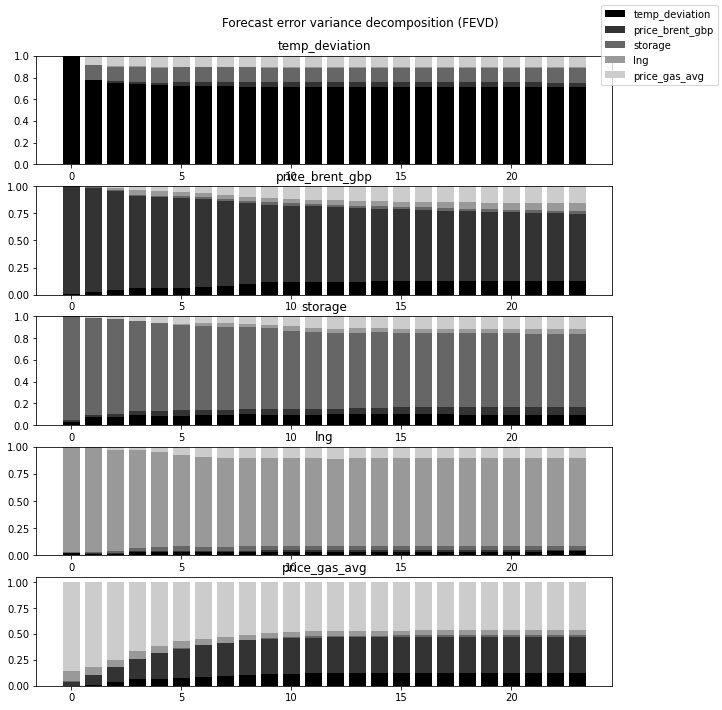

In [213]:
#### FEVD ####

#only for 20 periods
n=24
fevd = model_fit.fevd(n)
#fevd.summary()

#affichage pour n périodes
model_fit.fevd(n).plot()

[[ 1.50000000e-02  4.50565077e+01  1.53384100e-01  2.22849610e+00
   4.17152381e+01]
 [-1.08166667e+00  4.73093300e+01  6.08709000e-02  2.49839010e+00
   3.69485000e+01]
 [ 1.06166667e+00  4.49432712e+01  5.58932100e-01  1.42416000e-02
   2.87140909e+01]
 [ 1.86000000e+00  3.99834160e+01  5.81384700e-01  6.86966000e-02
   2.21625000e+01]
 [ 1.74666667e+00  2.38247622e+01  2.16780500e-01  1.61522000e-02
   2.16990909e+01]
 [ 3.83333333e-02  1.35830757e+01 -5.58022300e-01  2.11958870e+00
   1.49985000e+01]
 [ 1.85333333e+00  2.19346804e+01 -9.19516000e-02  1.59333100e+00
   1.15842857e+01]
 [ 1.35666667e+00  3.01212952e+01 -1.78540000e-01  1.16100170e+00
   1.33640909e+01]
 [ 6.13333333e-01  3.02133077e+01 -1.44151000e-01  6.52596200e-01
   1.39008696e+01]
 [-4.58333333e-01  3.08442444e+01 -6.37660000e-03  8.24209600e-01
   2.22060000e+01]
 [ 1.92000000e+00  2.91435837e+01  2.22631600e-01  7.96784400e-01
   3.03681818e+01]
 [ 4.31666667e-01  2.84483243e+01 -2.20169500e-01  6.92035700e-01

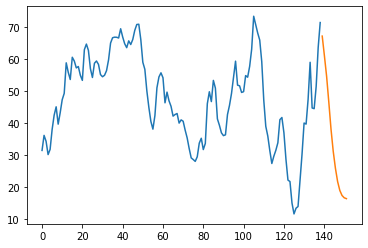

In [214]:
#### Forecast ####

#from fractions import Fraction


from numpy import linspace


yarray=df_corr.to_numpy()
#print(y)
y=yarray[119:,:]
print(y)
print(y.size)
ResSVAR.exog = None
ResSVAR.coefs_exog = np.array(0)
ResSVAR.trend = "n"

steps = 12
ForecastSVAR = ResSVAR.forecast(y,steps)

print(ForecastSVAR)
ForecastPriceGas = ForecastSVAR[:,4]

serie=yarray[:,4]
print(serie.size)
length=serie.size
xserie = np.linspace(0,length-1,length)
xforecast = np.linspace(length,length+steps,steps)

print(xserie.size)
print(xforecast.size)


print()
plt.plot(xserie,serie)
plt.plot(xforecast,ForecastPriceGas)
plt.show()


In [2]:
#### DIFF INV ####
diff_total = np.concatenate((yarray[:,6], ForecastPriceGas), axis=0)
#print(yarray[:,4])
#print(set_total)

length_set = yarray[:,6].size + steps
print(length_set)
PriceReal = np.linspace(0,length_set,length_set)
PriceReal[0] = dprice_gas.values[0]

for i in range(1,length_set):
    PriceReal[i] = diff_total[i-1] + PriceReal[i-1]

print(PriceReal)
forecasted = PriceReal[-steps:]
print(forecasted)
print(PriceReal.size)

plt.plot(PriceReal, color='blue')
plt.plot(xforecast,forecasted,color="green")
plt.show()


NameError: name 'np' is not defined

In [3]:
ForecastIntSVAR = ResSVAR.forecast_interval(y,steps)
print(ForecastIntSVAR)

# differenciated
UpBandDiff = ForecastIntSVAR[2][:,4]
LowBandDiff = ForecastIntSVAR[1][:,4]
MidDiff = ForecastIntSVAR[0][:,4]

plt.figure(figsize=(18, 10))
plt.plot(xforecast,UpBandDiff, color ="green",linestyle='dashed')
plt.plot(xforecast,LowBandDiff, color="green",linestyle='dashed')
plt.plot(xforecast,MidDiff,color="blue")
plt.show()


# integrated
last_val = dprice_gas.values[-1]

UpBand = UpBandDiff
LowBand = LowBandDiff 

UpBand[0] = last_val
LowBand[0] = last_val

for i in range(1,steps):
    UpBand[i] = UpBand[i-1] + UpBandDiff[i]
    LowBand[i] = LowBand[i-1] + LowBandDiff[i]

print(LowBand)
xforecast = np.linspace(length,length+steps,steps)

plt.figure(figsize=(18, 10))
plt.plot(xforecast,UpBand, color ="green",linestyle='dashed')
plt.plot(xforecast,LowBand, color ="green",linestyle='dashed')
plt.plot(PriceReal)
plt.show()

ResSVAR.plot_forecast(steps)

#ResSVAR.plotsim()

NameError: name 'ResSVAR' is not defined

In [ ]:
long_run = ResSVAR.test_inst_causality("lng")
long_run.summary()

Test statistic,Critical value,p-value,df
14.67,9.488,0.005,4


(array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00]],

       [[ 3.27985858e-01, -1.60727897e-02, -1.81425755e+00,
         -7.02396653e-01, -1.50696122e-01],
        [-8.84334676e-01,  9.56424595e-01, -3.33415208e-01,
         -3.89931120e-03, -8.22198134e-02],
        [-6.32213891e-03, -2.54457858e-02,  1.84640970e-01,
         -1.66068303e-01, -2.53751746e-02],
        [-3.52012908e-02, -1.15774907e-02, -2.72557798e-01,
          5.48736568e-01, -1.21655838e-02],
        [-6.32399658e-01, -1.88265640e-02, -1.96790765e+00,
 

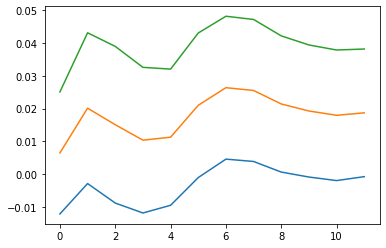

12
12
[ 64.14726783 131.31129405 192.31584363 246.89275739 293.40099558
 331.4707939  362.67673389 388.57023298 410.29348136 429.24584459
 446.6202068  463.26186799]
64.14726783468105
[67.16402621736603, 61.004549575521644, 54.576913766777366, 46.508238186256904, 38.06979831523435, 31.2059399949588, 25.89349909293752, 21.723248378238928, 18.95236322517856, 17.37436221641041, 16.64166118826725, 16.3802128967856]
12


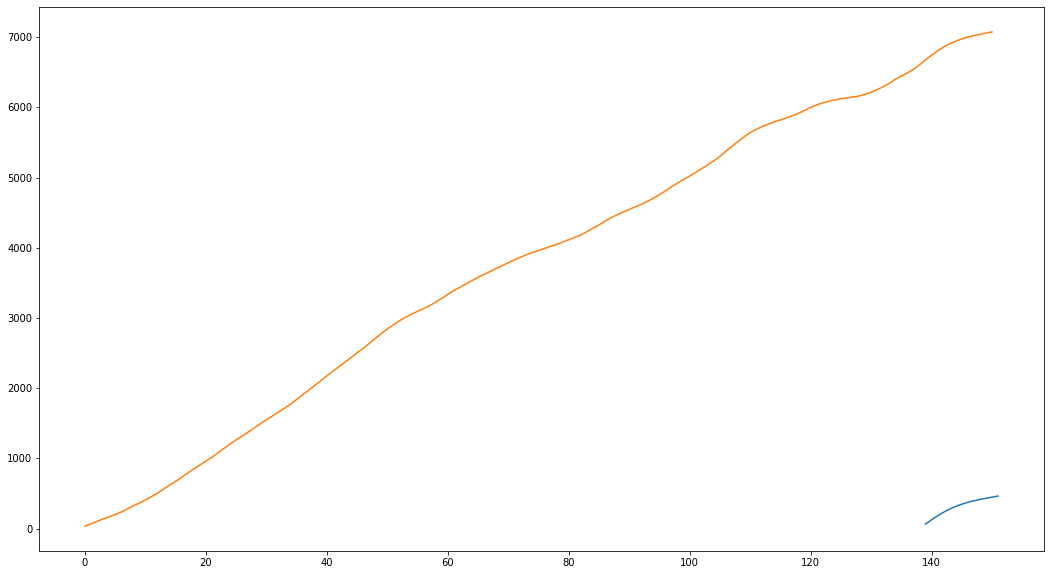

In [ ]:
#### SCENARIOS FORECAST ####

ResimBand = ResSVAR.irf_errband_mc(steps=steps,cum=False) #Tuple of lower and upper arrays of ma_rep monte carlo standard errors
Resim = ResSVAR.irf_resim()
print(ResimBand)

print(ResimBand[0])
UpperBand = []
LowerBand = []
Mid = []

for i in range(1,steps+1):
    UpperBand.append(ResimBand[0][i][3][4])
    LowerBand.append(ResimBand[1][i][3][4])



print("---------------------------")
print(UpperBand)

print("---------------------------")
print(LowerBand)


for i in range(0, steps):
    Mid.append((UpperBand[i] + LowerBand[i])/2)


plt.plot(UpperBand)
plt.plot(Mid)
plt.plot(LowerBand)
plt.show()

###########################

MidDiffTot = []
diff_forecast = diff_total[-steps:]
print(len(diff_forecast))
print(len(Mid))
for i in range(0,len(Mid)):
    MidDiffTot.append(Mid[i] + diff_forecast[i])

MidImp = np.linspace(0,steps,steps)
MidImp[0] = last_val

for i in range(1,steps):
    MidImp[i] = MidImp[i-1] + MidDiffTot[i-1]

print(MidImp)
print(last_val)
print(MidDiffTot)
print(len(MidImp))
plt.figure(figsize=(18, 10))
plt.plot(xforecast,MidImp)
plt.plot(PriceReal)
plt.show()